In [1]:
import torch
import torch.nn as nn 
from torchinfo import summary

In [2]:
# 定义AlexNet的网络结构
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000, dropout=0.5):
        super().__init__()
        # 定义卷积层
        self.features = nn.Sequential(
            # 卷积+ReLU+最大池化
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 卷积+ReLU+最大池化
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 卷积+ReLU
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # 卷积+ReLU
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # 卷积+ReLU
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # 最大池化
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
    
        # 定义全连接层
        self.classifier = nn.Sequential(
            # Dropout+全连接层+ReLU
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            # Dropout+全连接层+ReLU
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            # 全连接层
            nn.Linear(4096, num_classes),
        )

    # 定义前向传播函数
    def forward(self, x):
        # 先经过feature提取特征，flatten后送入全连接层
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x        

In [3]:
summary(AlexNet(), input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 1000]                 --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 55, 55]           23,296
│    └─ReLU: 2-2                         [1, 64, 55, 55]           --
│    └─MaxPool2d: 2-3                    [1, 64, 27, 27]           --
│    └─Conv2d: 2-4                       [1, 192, 27, 27]          307,392
│    └─ReLU: 2-5                         [1, 192, 27, 27]          --
│    └─MaxPool2d: 2-6                    [1, 192, 13, 13]          --
│    └─Conv2d: 2-7                       [1, 384, 13, 13]          663,936
│    └─ReLU: 2-8                         [1, 384, 13, 13]          --
│    └─Conv2d: 2-9                       [1, 256, 13, 13]          884,992
│    └─ReLU: 2-10                        [1, 256, 13, 13]          --
│    └─Conv2d: 2-11                      [1, 256, 13, 13]         

In [27]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import *
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 设置随机种子
torch.manual_seed(0)

# 定义模型、优化器、损失函数
model = AlexNet(num_classes=102).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# 设置训练集的数据变换，进行数据增强
trainform_train = transforms.Compose([
    transforms.RandomRotation(30),  # 随机旋转 -30度到30度之间
    transforms.RandomResizedCrop((224, 224)),  # 随机裁剪调整大小进行resize
    transforms.RandomHorizontalFlip(p = 0.5),  # 随机水平翻转
    transforms.RandomVerticalFlip(p = 0.5),  # 随机垂直翻转
    transforms.ToTensor(),  # 将图片转换为张量
    # 对三通道数据进行归一化(均值，标准差)，数值是从ImageNet数据集上的百万张图片中随机抽样计算得到
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 设置测试集的数据变换，不进行数据增强，仅使用resize和归一化
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  # resize
    transforms.ToTensor(),  # 将数据转换为张量
    # 对三通道数据进行归一化(均值，标准差)，数值是从ImageNet数据集上的百万张图片中随机抽样计算得到
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 加载训练数据，需要特别注意的是Flowers102数据集，test集的数据量较多些，所以这里使用"test"作为训练集
train_dataset = datasets.Flowers102(root='../data/flowers102', split="test",
                                    download=True, transform=trainform_train)
# 实例化训练数据加载器
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=10, pin_memory=True)

# 加载测试数据，使用"train"作为测试集
test_dataset = datasets.Flowers102(root='../data/flowers102', split="train",
                                   download=True, transform=transform_test)
# 实例化测试数据加载器
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=10, pin_memory=True)

In [21]:
# 设置epoch数并开始训练
num_epochs = 200  # 设置epoch数
loss_history = []  # 创建损失历史记录列表
acc_history = []   # 创建准确率历史记录列表

In [22]:
import sys 

In [28]:
# tqdm用于显示进度条并评估在每时间开销
for epoch in tqdm(range(num_epochs), file=sys.stdout):
    # 记录损失和预测正确数
    total_loss = 0
    total_correct = 0
    
    # 批量训练
    model.train()
    for inputs, labels in train_loader:
        # 将数据转移到指定计算资源设备上
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        # 预测、损失函数、反向传播
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # 记录训练集loss
        total_loss += loss.item()
        
        '''
        # 测试模型，不计算梯度
        model.eval()
        with torch.no_grad():
            for inputs, labels in test_loader:
                # 将数据转移到指定计算资源设备上
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # 预测
                outputs = model(inputs)
                # 记录测试集预测正确数
                total_correct += (outputs.argmax(1) == labels).sum().item()
        
        # 记录训练集损失和测试集准确率
        loss_history.append(np.log10(total_loss))  # 将损失加入损失历史记录列表，由于数值有时较大，这里取对数
        acc_history.append(total_correct / len(test_dataset)) # 将准确率加入准确率历史记录列表
        '''
        
    # 打印中间值
    if epoch % 50 == 0:
        model.eval()
        with torch.no_grad():
            for inputs, labels in test_loader:
                # 将数据转移到指定计算资源设备上
                inputs = inputs.to(device)
                labels = labels.to(device)
                # 预测
                outputs = model(inputs)
                # 记录测试集预测正确数
                total_correct += (outputs.argmax(1) == labels).sum().item()
        loss_history.append(np.log10(total_loss))  # 将损失加入损失历史记录列表，由于数值有时较大，这里取对数
        acc_history.append(total_correct / len(test_dataset)) # 将准确率加入准确率历史记录列表
        tqdm.write("Epoch: {0} Loss: {1} Acc: {2}".format(epoch, loss_history[-1], acc_history[-1]))

Epoch: 0 Loss: 2.3551457060227414 Acc: 0.00980392156862745                      
Epoch: 50 Loss: 2.11616678134685 Acc: 0.24803921568627452                       
Epoch: 100 Loss: 2.005655670486576 Acc: 0.37450980392156863                     
Epoch: 150 Loss: 1.7863894755335579 Acc: 0.5696078431372549                     
 92%|█████████████████████████████████████▋   | 184/200 [17:26<01:30,  5.69s/it]


Exception in thread Thread-495 (_pin_memory_loop):
Traceback (most recent call last):
  File "/home/utopia/anaconda3/envs/nn/lib/python3.12/threading.py", line 1052, in _bootstrap_inner
    self.run()
  File "/home/utopia/anaconda3/envs/nn/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/home/utopia/anaconda3/envs/nn/lib/python3.12/threading.py", line 989, in run


KeyboardInterrupt: 

    self._target(*self._args, **self._kwargs)
  File "/home/utopia/anaconda3/envs/nn/lib/python3.12/site-packages/torch/utils/data/_utils/pin_memory.py", line 54, in _pin_memory_loop
    do_one_step()
  File "/home/utopia/anaconda3/envs/nn/lib/python3.12/site-packages/torch/utils/data/_utils/pin_memory.py", line 31, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/utopia/anaconda3/envs/nn/lib/python3.12/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/utopia/anaconda3/envs/nn/lib/python3.12/site-packages/torch/multiprocessing/reductions.py", line 495, in rebuild_storage_fd
    fd = df.detach()
         ^^^^^^^^^^^
  File "/home/utopia/anaconda3/envs/nn/lib/python3.12/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
         ^^^^^^^^^^^^^^^^^^^^^^^

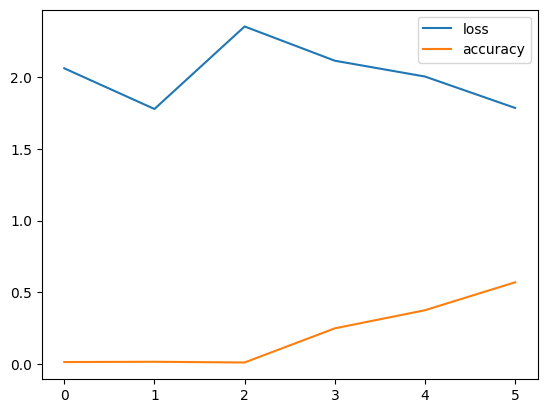

Accuracy: 0.5696078431372549


In [29]:
# 使用Matplotlib绘制损失和准确率的曲线图
import matplotlib.pyplot as plt
plt.plot(loss_history, label='loss')
plt.plot(acc_history, label='accuracy')
plt.legend()
plt.show()

print("Accuracy:",acc_history[-1])

参数设置：
值得注意的一点是调高batch_size没有明显提高速度，但是调低提高速度了。怀疑是cpu瓶颈了。所以有时候不能只看cpu。所以什么时候换12700f。